# Next Generation Reservoir Computing (NG-RC)

## Application to the Lorenz63 System

This notebook demonstrates the Next Generation Reservoir Computing (NG-RC) framework applied to the Lorenz63 system.

The implementation follows the methodology introduced by:

*Daniel J. Gauthier, Erik Bollt, Aaron Griffith,  
Wendson A. S. Barbosa.*

Here, the goal is to show how NG-RC can learn and predict the chaotic dynamics of the Lorenz63 system in a clear and instructional way.


In [1]:
# Source: LorenzConstLinQuadraticNVARtimedelay-RK23.py

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## 1. Simulation Setup

All time quantities are expressed in Lorenz time units.

| Symbol | Value | Description |
|--------|--------|-------------|
| $dt$ | 0.025 | Time step size, $t_{n+1} = t_n + dt$ |
| $T_{\text{warmup}}$ | 5.0 | Transient period (discarded) |
| $T_{\text{train}}$ | 10.0 | Training duration |
| $T_{\text{test}}$ | 120.0 | Prediction duration |
| $T_{\text{total}}$ | 135.0 | Total simulation time, $T_{\text{warmup}} + T_{\text{train}} + T_{\text{test}}$ |
| $T_{\text{plot}}$ | 20.0 | Portion of prediction interval shown |
| $T_{\lambda}$ | 1.104 | Lyapunov time |


In [2]:
## Parameters

# Time step of numerical integration
dt = 0.025

# Warm-up time (no training; allows transients to decay)
warmup = 5.0

# Training duration (used to learn output weights)
traintime = 10.0

# Testing duration (model prediction phase)
testtime = 120.0

# Total simulation time
maxtime = warmup + traintime + testtime

# Portion of test duration shown in plots
plottime = 20.0

# Lyapunov time of the Lorenz system (predictability scale)
lyaptime = 1.104


### 1.1 Discrete-Time Parameters

Time is discretized using a fixed step size $dt$.  
Each continuous-time interval is converted into a number of discrete samples by dividing by $dt$.

| Name | Symbol | Definition | Value |
|------|--------|------------|--------|
| Warmup samples | $N_{\text{warmup}}$ | $T_{\text{warmup}} / dt$ | 200 |
| Training samples | $N_{\text{train}}$ | $T_{\text{train}} / dt$ | 400 |
| Warmup + Training samples | $N_{\text{warm+train}}$ | $N_{\text{warmup}} + N_{\text{train}}$ | 600 |
| Testing samples | $N_{\text{test}}$ | $T_{\text{test}} / dt$ | 4800 |
| Total samples | $N_{\text{total}}$ | $T_{\text{total}} / dt$ | 5400 |
| Plot samples | $N_{\text{plot}}$ | $T_{\text{plot}} / dt$ | 800 |
| Samples per Lyapunov time | $N_{\lambda}$ | $T_{\lambda} / dt$ | 44 |


In [3]:
# Convert time durations to discrete sample counts

warmup_pts    = round(warmup / dt)        # Number of warm-up samples
traintime_pts = round(traintime / dt)     # Number of training samples
warmtrain_pts = warmup_pts + traintime_pts  # Samples before prediction
testtime_pts  = round(testtime / dt)      # Number of testing samples
maxtime_pts   = round(maxtime / dt)       # Total number of samples
plottime_pts  = round(plottime / dt)      # Samples shown in plots
lyaptime_pts  = round(lyaptime / dt)      # Lyapunov time in samples

# Display computed sample counts
print("warmup_pts    =", warmup_pts)
print("traintime_pts =", traintime_pts)
print("warmtrain_pts =", warmtrain_pts)
print("testtime_pts  =", testtime_pts)
print("maxtime_pts   =", maxtime_pts)
print("plottime_pts  =", plottime_pts)
print("lyaptime_pts  =", lyaptime_pts)


warmup_pts    = 200
traintime_pts = 400
warmtrain_pts = 600
testtime_pts  = 4800
maxtime_pts   = 5400
plottime_pts  = 800
lyaptime_pts  = 44


### 1.2 NVAR Feature Parameters
The following parameters define the dimensional structure of the NVAR feature space constructed from delayed Lorenz states.


| Name | Symbol | Definition | Value |
|------|--------|------------|--------|
| Input dimension | $d$ | Number of state variables $(x, y, z)$ | 3 |
| Number of delay taps | $k$ | Number of time delay copies | 2 |
| Linear feature dimension | $d_{\text{lin}}$ | $k \cdot d$ | 6 |
| Quadratic feature dimension | $d_{\text{nonlin}}$ | $\dfrac{d_{\text{lin}}(d_{\text{lin}} + 1)}{2}$ | 21 |
| Total feature dimension | $d_{\text{tot}}$ | $1 + d_{\text{lin}} + d_{\text{nonlin}}$ | 28 |


In [4]:
# NVAR feature parameters

d = 3                 # Input dimension (x, y, z)
k = 2                 # Number of time-delay taps

dlin = k * d          # Linear feature dimension
dnonlin = int(dlin * (dlin + 1) / 2)  # Quadratic feature dimension

dtot = 1 + dlin + dnonlin  # Total feature dimension (constant + linear + quadratic)

# Display feature dimensions
print("d       =", d)
print("k       =", k)
print("dlin    =", dlin)
print("dnonlin =", dnonlin)
print("dtot    =", dtot)

d       = 3
k       = 2
dlin    = 6
dnonlin = 21
dtot    = 28


### 1.3 Regression and Time Grid

The following parameters define the regression regularization and the discrete evaluation time grid.

| Name | Symbol | Definition |
|------|--------|------------|
| Ridge regularization parameter | $\alpha$ | Controls the strength of regularization |
| Evaluation time grid | $t_{\text{eval}}$ | $t_{\text{eval}} \in [0, T_{\text{total}}]$ with $N_{\text{total}} + 1$ discrete points |


In [5]:
# Ridge regression parameter (regularization strength)
ridge_param = 2.5e-6

# Time grid for full simulation interval
# (maxtime_pts + 1 ensures spacing of dt)
t_eval = np.linspace(0, maxtime, maxtime_pts + 1)

## 2. Lorenz63 System

The Lorenz63 system is a three-dimensional nonlinear system that exhibits chaotic behavior.

$$
\begin{aligned}
\dot{x}(t) &= \sigma \big(y(t) - x(t)\big) \\
\dot{y}(t) &= x(t)\big(\rho - z(t)\big) - y(t) \\
\dot{z}(t) &= x(t)y(t) - \beta z(t)
\end{aligned}
$$

**Parameters**
$$
(\sigma, \rho, \beta) = \left(10, 28, \frac{8}{3}\right)
$$

These parameter values produce chaotic dynamics.


In [6]:
# Lorenz–63 parameters
sigma = 10
beta = 8 / 3
rho = 28

# Lorenz system definition
def lorenz(t, y):
    """
    Computes time derivatives for the Lorenz-63 system.
    
    Parameters:
        t : float
            Current time (required by solve_ivp)
        y : array-like
            State vector [x, y, z]
            
    Returns:
        list
            Time derivatives [dx/dt, dy/dt, dz/dt]
    """
    
    dx = sigma * (y[1] - y[0])
    dy = y[0] * (rho - y[2]) - y[1]
    dz = y[0] * y[1] - beta * y[2]
    
    return [dx, dy, dz]


### 2.1 Lorenz Time-Series Generation


The Lorenz63 system is integrated over $[0, T_{\text{total}}]$  
and sampled at fixed time intervals $dt$.

$$
t_n = n\,dt, \quad n = 0, 1, \dots, N_{\text{total}}.
$$

**Initial condition**

$$
(x(0), y(0), z(0)) = (17.6772,\; 12.9314,\; 43.9140)
$$

The discrete state vector is

$$
\mathbf{x}(t_n) =
\begin{bmatrix}
x(t_n) \\
y(t_n) \\
z(t_n)
\end{bmatrix}.
$$

This produces the trajectories $x(t_n)$, $y(t_n)$, and $z(t_n)$.


In [7]:
# Integrate the Lorenz system to generate time-series data
# Initial condition lies on the attractor to ensure typical chaotic dynamics

lorenz_soln = solve_ivp(
    lorenz,                         # Lorenz system function
    (0, maxtime),                   # Time interval
    [17.67715816276679,
     12.931379185960404,
     43.91404334248268],            # Initial state [x0, y0, z0]
    t_eval=t_eval,                  # Discrete evaluation times
    method='RK23'                   # Runge–Kutta method
)

print("Solution status:", lorenz_soln.message)
print("State array shape:", lorenz_soln.y.shape)


Solution status: The solver successfully reached the end of the integration interval.
State array shape: (3, 5401)


### 2.2 Total Variance

The total variance is defined as the sum of the variances of the three state components:

$$
\mathrm{Var}_{\text{total}}
=
\mathrm{Var}\big(x(t_n)\big)
+
\mathrm{Var}\big(y(t_n)\big)
+
\mathrm{Var}\big(z(t_n)\big).
$$

This is used to normalize the prediction error.

The initial condition is chosen on the Lorenz attractor to ensure typical chaotic behavior.


In [8]:
# Compute total variance across all state variables (x, y, z)
# Used later to normalize prediction error
total_var = np.var(lorenz_soln.y[0:d, :])

print("Total variance =", total_var)

Total variance = 204.5411495503244


### 2.3 Generated Data and Splitting

After integration, the full trajectory is stored as

$$
\mathbf{X}_{\text{full}}
=
\begin{bmatrix}
x(t_0) & \cdots & x(t_{N_{\text{total}}}) \\
y(t_0) & \cdots & y(t_{N_{\text{total}}}) \\
z(t_0) & \cdots & z(t_{N_{\text{total}}})
\end{bmatrix}
\in \mathbb{R}^{3 \times (N_{\text{total}}+1)}.
$$

The matrix is partitioned sequentially along the time axis:

$$
\mathbf{X}_{\text{full}}
=
\big[
\mathbf{X}_{\text{warmup}}
\;\big|\;
\mathbf{X}_{\text{train}}
\;\big|\;
\mathbf{X}_{\text{test}}
\big],
$$

where

$$
\mathbf{X}_{\text{warmup}} \in \mathbb{R}^{3 \times N_{\text{warmup}}},
\quad
\mathbf{X}_{\text{train}} \in \mathbb{R}^{3 \times N_{\text{train}}},
\quad
\mathbf{X}_{\text{test}} \in \mathbb{R}^{3 \times N_{\text{test}}}.
$$


## 3. NVAR Feature Construction

The NVAR feature vector at time $t$ is built as

$$
\boldsymbol{\phi}(\mathbf{x}(t)) =
\begin{bmatrix}
\text{Bias} \\
\text{Linear Delay Terms} \\
\text{Nonlinear Terms}
\end{bmatrix}.
$$

- The bias term is a constant equal to 1.
- The linear features $\boldsymbol{\phi}_{\text{lin}}(t)$ contain the current state and the delayed states.
- The nonlinear features $\boldsymbol{\phi}_{\text{nonlin}}(t)$ consist of products of the linear features.

The complete feature vector is formed by combining the bias, linear, and nonlinear terms, and this combined vector is used for training.



### 3.1 NVAR Linear Features

The linear feature vector at time $t$ is

$$
\boldsymbol{\phi}_{\text{lin}}(t)
=
\begin{bmatrix}
x(t) \\
y(t) \\
z(t) \\
x(t-\tau) \\
y(t-\tau) \\
z(t-\tau)
\end{bmatrix}.
$$


With $d=3$ variables and $k=2$ taps (current + delay),

$$
d_{\text{lin}} = 6.
$$


In [9]:
# Construct linear (delay) feature matrix

# Array to store linear delay features
# Shape: (dlin, total_time_steps)
x = np.zeros((dlin, maxtime_pts))

# Fill delay features using Lorenz time series
for delay in range(k):
    for j in range(delay, maxtime_pts):
        x[d*delay:d*(delay+1), j] = lorenz_soln.y[:, j - delay]

print("Linear feature matrix shape:", x.shape)

Linear feature matrix shape: (6, 5400)


### 3.2 Training Feature Matrix Construction

After removing the warmup samples, the NVAR training feature matrix is constructed as

$$
\mathbf{\Phi}_{\text{train}} =
\begin{bmatrix}
1 \\
\boldsymbol{\phi}_{\text{lin}}(t) \\
\text{quadratic terms}
\end{bmatrix}.
$$

- The first row is the bias term.
- The linear and quadratic features follow.
- Only training time steps are included.


In [10]:
# Construct training feature matrix (constant + linear)

# Initialize with ones (first row = bias term)
out_train = np.ones((dtot, traintime_pts))

# Insert linear features (excluding warm-up region)
out_train[1:dlin+1, :] = x[:, warmup_pts-1:warmtrain_pts-1]

print("Training feature matrix shape:", out_train.shape)

Training feature matrix shape: (28, 400)


### 3.3 NVAR Nonlinear Features

To capture nonlinear dynamics, we add:

- Squared terms, such as $x(t)^2$, $y(t)^2$, $x(t-\tau)^2$.
- Interaction terms, such as $x(t)y(t)$ and $x(t)x(t-\tau)$.

In total, this gives 21 quadratic features.




These form the nonlinear feature vector

$$
\boldsymbol{\phi}_{\text{nonlin}}(t)
=
\begin{bmatrix}
x(t)^2 \\
y(t)^2 \\
x(t)y(t) \\
\vdots \\
x(t)x(t-\tau) \\
y(t)z(t-\tau)
\end{bmatrix}.
$$






In [11]:
# Construct nonlinear (quadratic) features for training

cnt = 0  # Counter to track quadratic feature index

for i in range(dlin):
    for j in range(i, dlin):
        # Multiply linear features to form quadratic terms
        out_train[dlin + 1 + cnt, :] = (
            x[i, warmup_pts-1:warmtrain_pts-1] *
            x[j, warmup_pts-1:warmtrain_pts-1]
        )
        cnt += 1

print("Nonlinear features added:", cnt)
print("Final training matrix shape:", out_train.shape)


Nonlinear features added: 21
Final training matrix shape: (28, 400)


### 3.4 Training Feature Matrix

The training feature matrix is constructed by stacking

- a bias term,
- the linear delay features,
- and the nonlinear (quadratic) features.

$$
\mathbf{\Phi}_{\text{train}} =
\begin{bmatrix}
1 \\
\boldsymbol{\phi}_{\text{lin}}(t) \\
\boldsymbol{\phi}_{\text{nonlin}}(t)
\end{bmatrix}.
$$

Each column corresponds to one training time step.


$$
\mathbf{\Phi}_{\text{train}} \in \mathbb{R}^{28 \times N_{\text{train}}}.
$$


## 4. Training the Output Weights

The output weight matrix $W_{\text{out}}$ is learned using ridge regression.
It maps the NVAR feature vector to the discrete state increment.

The model learns

$$
\Delta \mathbf{x}(t)
=
\mathbf{x}(t+1) - \mathbf{x}(t).
$$

Using the training feature matrix,

$$
\Delta \mathbf{X}_{\text{train}}
=
W_{\text{out}} \, \mathbf{\Phi}_{\text{train}}.
$$

The ridge regression solution is

$$
W_{\text{out}}
=
\Delta \mathbf{X}_{\text{train}}
\, \mathbf{\Phi}_{\text{train}}^{T}
\left(
\mathbf{\Phi}_{\text{train}} \mathbf{\Phi}_{\text{train}}^{T}
+ \alpha I
\right)^{-1},
$$

where $\alpha$ is the regularization parameter.

Only $W_{\text{out}}$ is trained; the feature construction remains fixed.


In [12]:
# Construct training target (state increment)
# Target = change in Lorenz state between consecutive time steps

Y = x[0:d, warmup_pts:warmtrain_pts] - \
    x[0:d, warmup_pts-1:warmtrain_pts-1]

print("Target matrix shape:", Y.shape)


# Ridge regression to compute output weights

W_out = (
    Y @ out_train.T @
    np.linalg.pinv(
        out_train @ out_train.T +
        ridge_param * np.identity(dtot)
    )
)

print("Output weight matrix shape:", W_out.shape)
print("First few values of W_out:")


Target matrix shape: (3, 400)
Output weight matrix shape: (3, 28)
First few values of W_out:


## 5. Training Prediction

After learning $W_{\text{out}}$, the model reconstructs the Lorenz trajectory
by predicting the state increment.

The model computes

$$
\Delta \mathbf{x}(t)
=
W_{\text{out}} \, \boldsymbol{\phi}(t),
$$

and the next state is obtained as

$$
\hat{\mathbf{x}}(t+1)
=
\mathbf{x}(t)
+
W_{\text{out}} \, \boldsymbol{\phi}(t).
$$

Since the model learns the increment
$\Delta \mathbf{x}(t) = \mathbf{x}(t+1) - \mathbf{x}(t)$,
prediction is performed by adding this increment to the current state.

In [13]:
# Predict training data using learned weights
# x(t+1) = x(t) + W_out Φ(t)

x_predict = (
    x[0:d, warmup_pts-1:warmtrain_pts-1] +
    W_out @ out_train[:, :traintime_pts]
)

print("Training prediction shape:", x_predict.shape)


Training prediction shape: (3, 400)


### 5.1 Training Error (NRMSE)

The normalized root mean square error (NRMSE) is defined as

$$
\text{NRMSE}
=
\sqrt{
\frac{
\mathrm{mean}\!\left( \| \mathbf{x}(t) - \hat{\mathbf{x}}(t) \|^2 \right)
}{
\mathrm{Var}_{\text{total}}
}
}.
$$

It measures the prediction error relative to the total variance of the system.


In [14]:
# Training error (NRMSE)

# Difference between true Lorenz states and predicted states
error = x[0:d, warmup_pts:warmtrain_pts] - x_predict

# Normalized Root Mean Square Error
rms = np.sqrt(np.mean(error**2) / total_var)

print("Training NRMSE:", rms)


Training NRMSE: 0.00010251237643148848


## 6. Testing Phase Setup

For autonomous prediction:

- A feature vector container `out_test` is created for one time step.
- A matrix `x_test` is allocated to store predicted states.
- The first test state is initialized using the final training state.

Prediction then proceeds iteratively from this initial condition.


In [15]:
# Prepare storage for testing (prediction phase)

# Feature vector for one time step
out_test = np.zeros(dtot)

# Matrix to store predicted states during testing
x_test = np.zeros((dlin, testtime_pts))

# Initialize with final training state
x_test[:, 0] = x[:, warmtrain_pts - 1]

print("Testing state matrix shape:", x_test.shape)


Testing state matrix shape: (6, 4800)


### 6.1 Autonomous Prediction (Testing Phase)

During testing, the model runs recursively.

At each time step:

- The current delayed state is inserted into the feature vector.
- Quadratic features are constructed.
- Delay taps are shifted forward.
- The next state is predicted as

$$
\hat{\mathbf{x}}(t+1)
=
\hat{\mathbf{x}}(t)
+
W_{\text{out}} \, \boldsymbol{\phi}(t).
$$

The model uses its own previous prediction to generate the next state.

#### Test Error (NRMSE)

The prediction error is evaluated over one Lyapunov time:

$$
\text{NRMSE}
=
\sqrt{
\frac{
\mathrm{mean}\!\left(
\| \mathbf{x}(t) - \hat{\mathbf{x}}(t) \|^2
\right)
}{
\mathrm{Var}_{\text{total}}
}
}.
$$


In [16]:
# Autonomous prediction (testing phase)

for j in range(testtime_pts - 1):

    # Insert linear features (current delayed state)
    out_test[1:dlin+1] = x_test[:, j]

    # Construct quadratic features
    cnt = 0
    for row in range(dlin):
        for column in range(row, dlin):
            out_test[dlin + 1 + cnt] = (
                x_test[row, j] * x_test[column, j]
            )
            cnt += 1

    # Shift delay taps for next time step
    x_test[d:dlin, j+1] = x_test[0:(dlin - d), j]

    # Predict next state (add learned increment)
    x_test[0:d, j+1] = (
        x_test[0:d, j] + W_out @ out_test
    )


# Compute NRMSE over one Lyapunov time
true_segment = x[0:d,
                 warmtrain_pts-1 : warmtrain_pts+lyaptime_pts-1]

pred_segment = x_test[0:d, 0:lyaptime_pts]

test_nrmse = np.sqrt(
    np.mean((true_segment - pred_segment)**2) / total_var
)

print("Test prediction shape:", x_test.shape)
print("Lyapunov window length:", lyaptime_pts)
print("Test NRMSE (1 Lyapunov time):", test_nrmse)

Test prediction shape: (6, 4800)
Lyapunov window length: 44
Test NRMSE (1 Lyapunov time): 0.0006475238259387782


## 7. Testing Results and Performance Analysis

Visualization of the NGRC prediction compared to the true Lorenz trajectory.


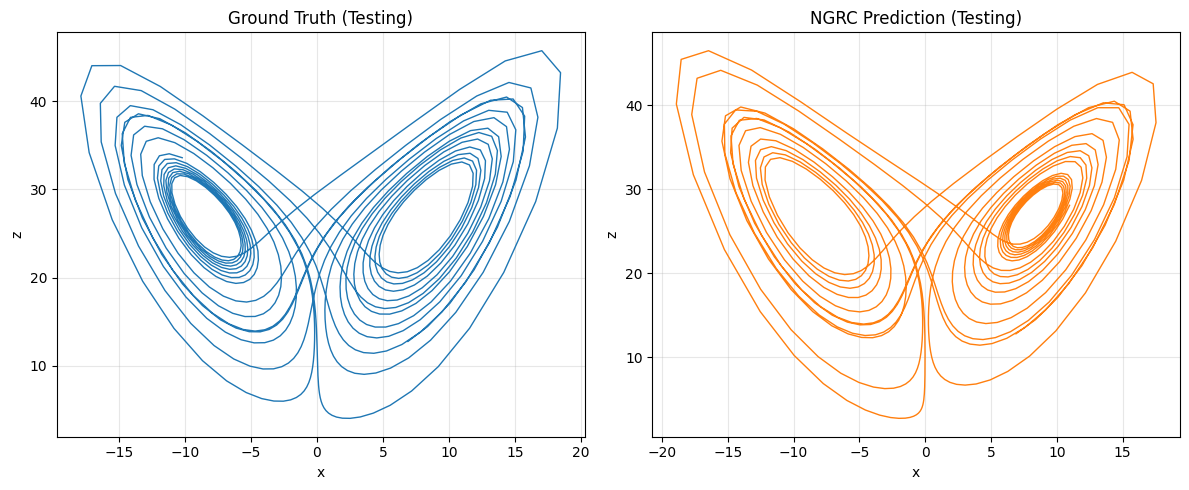

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

# Extract data (same alignment as animation/static error)
true_x = x[0, warmtrain_pts-1:warmtrain_pts+plottime_pts-1]
true_z = x[2, warmtrain_pts-1:warmtrain_pts+plottime_pts-1]

pred_x = x_test[0, :plottime_pts]
pred_z = x_test[2, :plottime_pts]

#  Left: Ground Truth 
axs[0].plot(true_x, true_z,
            color='tab:blue',
            linewidth=1)

axs[0].set_title('Ground Truth (Testing)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('z')
axs[0].grid(alpha=0.3)

#  Right: Prediction 
axs[1].plot(pred_x, pred_z,
            color='tab:orange',
            linewidth=1)

axs[1].set_title('NGRC Prediction (Testing)')
axs[1].set_xlabel('x')
axs[1].set_ylabel('z')
axs[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


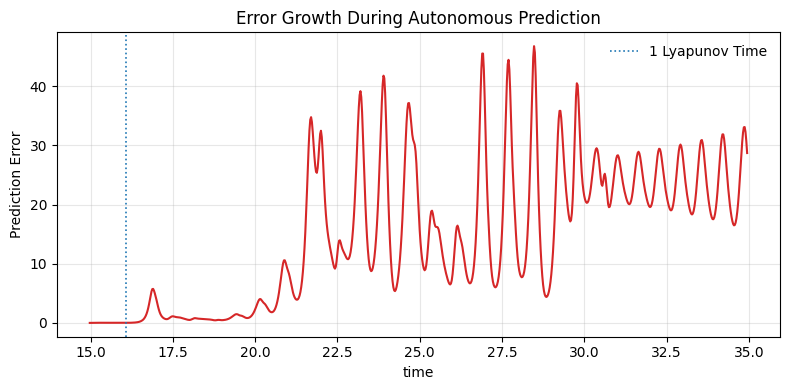

In [18]:
# Compute error magnitude (Euclidean norm at each time step)
true_slice = slice(warmtrain_pts - 1,
                   warmtrain_pts + plottime_pts - 1)

error = np.sqrt(
    np.sum(
        (x[0:3, true_slice] - x_test[0:3, :plottime_pts])**2,
        axis=0
    )
)

# Physical time axis
t_error = t_eval[true_slice]

# 1 Lyapunov time boundary
t_lyap = t_eval[warmtrain_pts - 1] + lyaptime_pts * (t_eval[1] - t_eval[0])

plt.figure(figsize=(8, 4))

plt.plot(t_error, error, linewidth=1.5,color='tab:red'
)

plt.axvline(t_lyap,
            linestyle=':',
            linewidth=1.2,
            label='1 Lyapunov Time')

plt.xlabel("time")
plt.ylabel("Prediction Error")
plt.title("Error Growth During Autonomous Prediction")
plt.grid(alpha=0.3)
plt.legend(frameon=False)

plt.tight_layout()
plt.show()


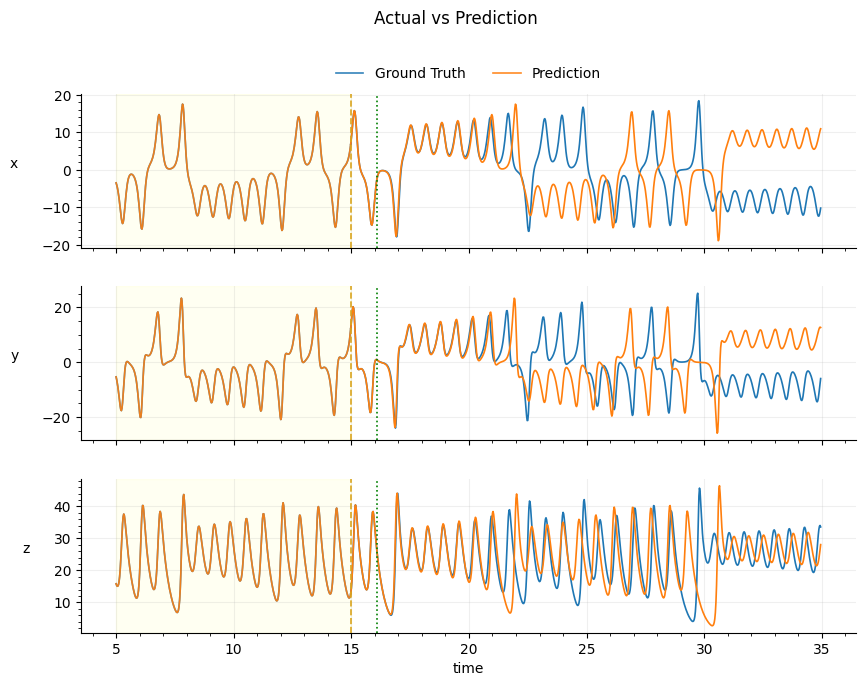

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

labels = ['x', 'y', 'z']

# Define slices clearly
train_slice = slice(warmup_pts, warmtrain_pts)
test_slice  = slice(warmtrain_pts - 1,
                    warmtrain_pts + plottime_pts - 1)

t_train = t_eval[train_slice]
t_test  = t_eval[test_slice]

t_boundary = t_eval[warmtrain_pts - 1]
dt_local = t_eval[1] - t_eval[0]
t_lyap = t_boundary + lyaptime_pts * dt_local

for i in range(3):

    # Training region shading
    axs[i].axvspan(t_train[0], t_boundary, color='yellow', alpha=0.05)

    # Training ground truth
    axs[i].plot(t_train,
                x[i, train_slice],
                color='tab:blue', linewidth=1.2, alpha=0.9,
                label='Ground Truth' if i == 0 else None)

    # Training prediction
    axs[i].plot(t_train,
                x_predict[i, :],
                color='tab:orange', linewidth=1.2, alpha=0.9,
                label='Prediction' if i == 0 else None)

    # Testing ground truth
    axs[i].plot(t_test, x[i, test_slice], color='tab:blue', linewidth=1.2)

    # Testing prediction
    axs[i].plot(t_test, x_test[i, :plottime_pts], color='tab:orange', linewidth=1.2)

    # Boundaries
    axs[i].axvline(t_boundary, linestyle='--', color='goldenrod', linewidth=1.2)

    axs[i].axvline(t_lyap, linestyle=':', color='green', linewidth=1.2)

    axs[i].grid(True, alpha=0.2)
    axs[i].set_ylabel(labels[i], rotation=0, labelpad=20)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].minorticks_on()

axs[0].legend(frameon=False, loc='lower center', bbox_to_anchor=(0.5, 1), ncol=2)

fig.suptitle('Actual vs Prediction', y=1)
axs[2].set_xlabel('time')

plt.subplots_adjust(hspace=0.25)
plt.show()

In [20]:
y_pos = np.arange(dtot)

labels = ['c','x(t)','y(t)','z(t)','x(t-dt)','y(t-dt)','z(t-dt)']
labels += ['x(t)x(t)','x(t)y(t)','x(t)z(t)',
           'x(t)x(t-dt)','x(t)y(t-dt)','x(t)z(t-dt)']
labels += ['y(t)y(t)','y(t)z(t)',
           'y(t)x(t-dt)','y(t)y(t-dt)','y(t)z(t-dt)']
labels += ['z(t)z(t)',
           'z(t)x(t-dt)','z(t)y(t-dt)','z(t)z(t-dt)']
labels += ['x(t-dt)x(t-dt)',
           'x(t-dt)y(t-dt)',
           'x(t-dt)z(t-dt)']
labels += ['y(t-dt)y(t-dt)',
           'y(t-dt)z(t-dt)']
labels += ['z(t-dt)z(t-dt)']


In [21]:
# Color highlighting for true Lorenz structure

# For dx/dt = sigma(y - x)
colorx = ['tab:orange',   # constant
          'tab:blue',     # x(t)
          'tab:blue']     # y(t)
colorx += ['tab:orange'] * (dtot - 3)

# For dy/dt = x(rho - z) - y
colory = ['tab:orange',   # constant
          'tab:blue',     # x(t)
          'tab:blue',     # y(t)
          'tab:orange',   # z(t)
          'tab:orange',   # x(t-dt)
          'tab:orange',   # y(t-dt)
          'tab:orange']   # z(t-dt)

# mark x(t)z(t) term blue (true nonlinear term)
colory += ['tab:orange'] * 2
colory += ['tab:blue']    # x(t)z(t)
colory += ['tab:orange'] * (dtot - len(colory))

# For dz/dt = xy - beta z
colorz = ['tab:orange',   # constant
          'tab:orange',   # x(t)
          'tab:orange',   # y(t)
          'tab:blue']     # z(t)

# mark x(t)y(t) term blue
colorz += ['tab:orange'] * 1
colorz += ['tab:blue']
colorz += ['tab:orange'] * (dtot - len(colorz))


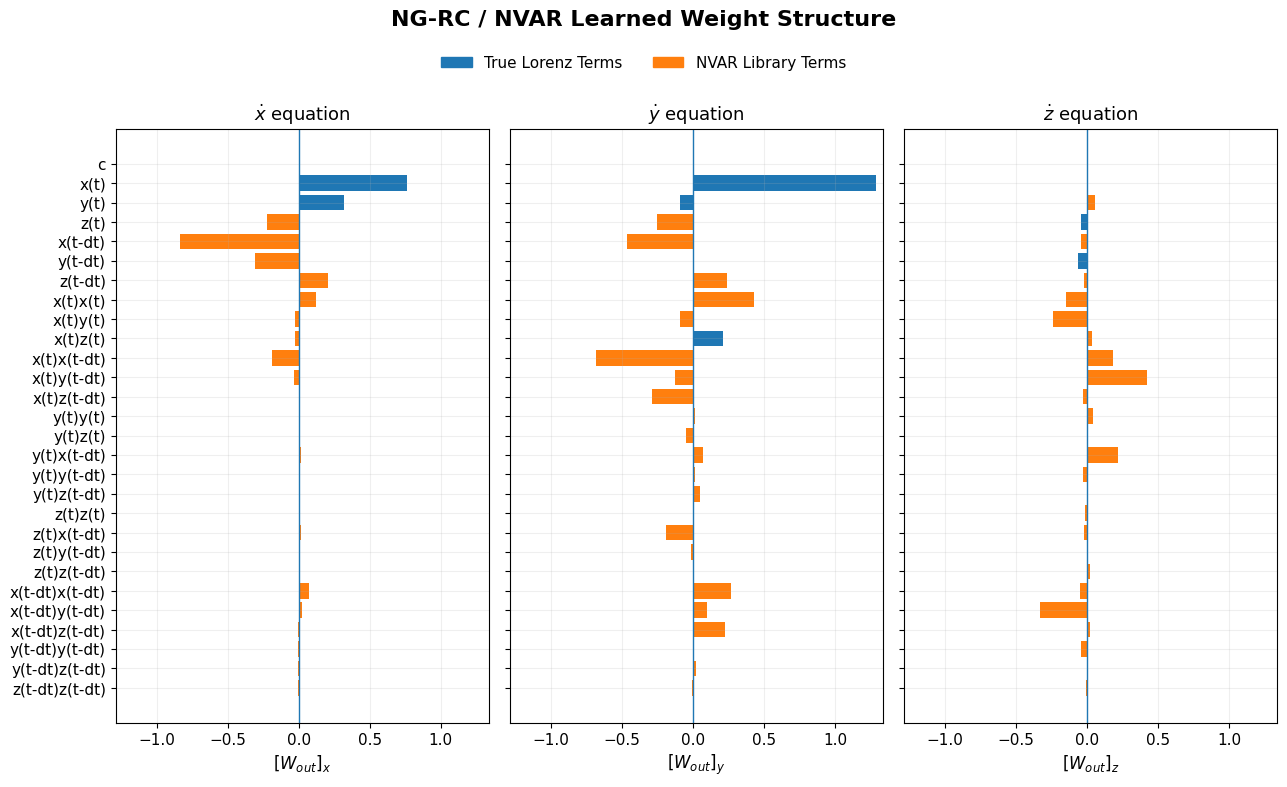

In [22]:
import matplotlib.patches as mpatches

plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 12
})

fig, axs = plt.subplots(1, 3, figsize=(13, 8), sharey=True)

# X equation
axs[0].barh(y_pos, W_out[0, :], color=colorx)
axs[0].set_yticks(y_pos)
axs[0].set_yticklabels(labels)
axs[0].set_xlabel(r'$[W_{out}]_x$')
axs[0].set_title(r'$\dot{x}$ equation')
axs[0].axvline(0, linewidth=1)
axs[0].grid(alpha=0.2)

# Y equation
axs[1].barh(y_pos, W_out[1, :], color=colory)
axs[1].set_xlabel(r'$[W_{out}]_y$')
axs[1].set_title(r'$\dot{y}$ equation')
axs[1].axvline(0, linewidth=1)
axs[1].grid(alpha=0.2)

# Z equation
axs[2].barh(y_pos, W_out[2, :], color=colorz)
axs[2].set_xlabel(r'$[W_{out}]_z$')
axs[2].set_title(r'$\dot{z}$ equation')
axs[2].axvline(0, linewidth=1)
axs[2].grid(alpha=0.2)

axs[0].invert_yaxis()

# Legend
true_patch = mpatches.Patch(color='tab:blue', label='True Lorenz Terms')
nvar_patch = mpatches.Patch(color='tab:orange', label='NVAR Library Terms')

fig.legend(handles=[true_patch, nvar_patch],
           loc='upper center',
           bbox_to_anchor=(0.5, 0.94),
           ncol=2,
           frameon=False)

fig.suptitle('NG-RC / NVAR Learned Weight Structure',
             fontsize=16,
             fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.93])

# Symmetric x-axis limits
max_val = np.max(np.abs(W_out))
for ax in axs:
    ax.set_xlim(-max_val, max_val + 0.05)

plt.show()


In [23]:
'''
%matplotlib notebook

import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 200

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Time settings
frames = plottime_pts
trail = 100

# Physical time window
t_error = t_eval[warmtrain_pts-1 : warmtrain_pts+plottime_pts-1]

# Error computation
dist = np.sqrt(
    np.sum(
        (x[0:3, warmtrain_pts-1:warmtrain_pts+plottime_pts-1]
         - x_test[0:3, :plottime_pts])**2,
        axis=0
    )
)

# Lyapunov time marker
dt = t_eval[1] - t_eval[0]
t_boundary = t_eval[warmtrain_pts-1]
t_lyap = t_boundary + lyaptime_pts * dt

# Create figure
fig = plt.figure(figsize=(13,6))
fig.suptitle("Actual vs Predicted Lorenz Trajectory", y=0.98)

# 3D Lorenz trajectories
ax3d = fig.add_subplot(121, projection='3d')

ax3d.set_xlim(np.min(x[0]), np.max(x[0]))
ax3d.set_ylim(np.min(x[1]), np.max(x[1]))
ax3d.set_zlim(np.min(x[2]), np.max(x[2]))


true_line, = ax3d.plot([], [], [], color='tab:blue', lw=2)
true_point, = ax3d.plot([], [], [], 'o', color='tab:blue')

pred_line, = ax3d.plot([], [], [], color='tab:orange', lw=2, linestyle='--')
pred_point, = ax3d.plot([], [], [], 'o', color='tab:orange')

ax3d.legend([true_line, pred_line],
            ["Ground Truth", "Prediction"],
            loc="upper left")


# Prediction error plot
ax_err = fig.add_subplot(122)

ax_err.set_xlim(t_error[0], t_error[-1])
ax_err.set_ylim(0, np.max(dist)*1.1)

ax_err.set_title("Prediction Error")
ax_err.set_xlabel("Time")
ax_err.set_ylabel("Euclidean Distance")
ax_err.grid(alpha=0.3)

ax_err.axvline(t_lyap, linestyle=':', color='tab:green', linewidth=1.2)
err_line, = ax_err.plot([], [], color='tab:red', lw=2, alpha=0.8)


# Initialize animation
def init():
    true_line.set_data([], [])
    true_line.set_3d_properties([])
    pred_line.set_data([], [])
    pred_line.set_3d_properties([])
    err_line.set_data([], [])
    return true_line, pred_line, true_point, pred_point, err_line

# Update animation
def update(frame):

    start = max(0, frame - trail)

    # Actual trajectory
    true_line.set_data(
        x[0, warmtrain_pts-1+start:warmtrain_pts-1+frame],
        x[1, warmtrain_pts-1+start:warmtrain_pts-1+frame]
    )
    true_line.set_3d_properties(
        x[2, warmtrain_pts-1+start:warmtrain_pts-1+frame]
    )

    true_point.set_data(
        [x[0, warmtrain_pts-1+frame]],
        [x[1, warmtrain_pts-1+frame]]
    )
    true_point.set_3d_properties(
        [x[2, warmtrain_pts-1+frame]]
    )

    # Predicted trajectory
    pred_line.set_data(
        x_test[0, start:frame],
        x_test[1, start:frame]
    )
    pred_line.set_3d_properties(
        x_test[2, start:frame]
    )

    pred_point.set_data(
        [x_test[0, frame]],
        [x_test[1, frame]]
    )
    pred_point.set_3d_properties(
        [x_test[2, frame]]
    )

    # Error evolution
    err_line.set_data(t_error[:frame], dist[:frame])
    

    return true_line, pred_line, true_point, pred_point, err_line

# Create animation
ani = FuncAnimation(
    fig,
    update,
    frames=frames,
    init_func=init,
    interval=30,
    blit=False
)

HTML(ani.to_jshtml())

''' 

'\n%matplotlib notebook\n\nimport matplotlib as mpl\nmpl.rcParams[\'animation.embed_limit\'] = 200\n\nfrom matplotlib.animation import FuncAnimation\nfrom IPython.display import HTML\n\n# Time settings\nframes = plottime_pts\ntrail = 100\n\n# Physical time window\nt_error = t_eval[warmtrain_pts-1 : warmtrain_pts+plottime_pts-1]\n\n# Error computation\ndist = np.sqrt(\n    np.sum(\n        (x[0:3, warmtrain_pts-1:warmtrain_pts+plottime_pts-1]\n         - x_test[0:3, :plottime_pts])**2,\n        axis=0\n    )\n)\n\n# Lyapunov time marker\ndt = t_eval[1] - t_eval[0]\nt_boundary = t_eval[warmtrain_pts-1]\nt_lyap = t_boundary + lyaptime_pts * dt\n\n# Create figure\nfig = plt.figure(figsize=(13,6))\nfig.suptitle("Actual vs Predicted Lorenz Trajectory", y=0.98)\n\n# 3D Lorenz trajectories\nax3d = fig.add_subplot(121, projection=\'3d\')\n\nax3d.set_xlim(np.min(x[0]), np.max(x[0]))\nax3d.set_ylim(np.min(x[1]), np.max(x[1]))\nax3d.set_zlim(np.min(x[2]), np.max(x[2]))\n\n\ntrue_line, = ax3d.plot(

In [24]:
plt.close('all')
%matplotlib inline

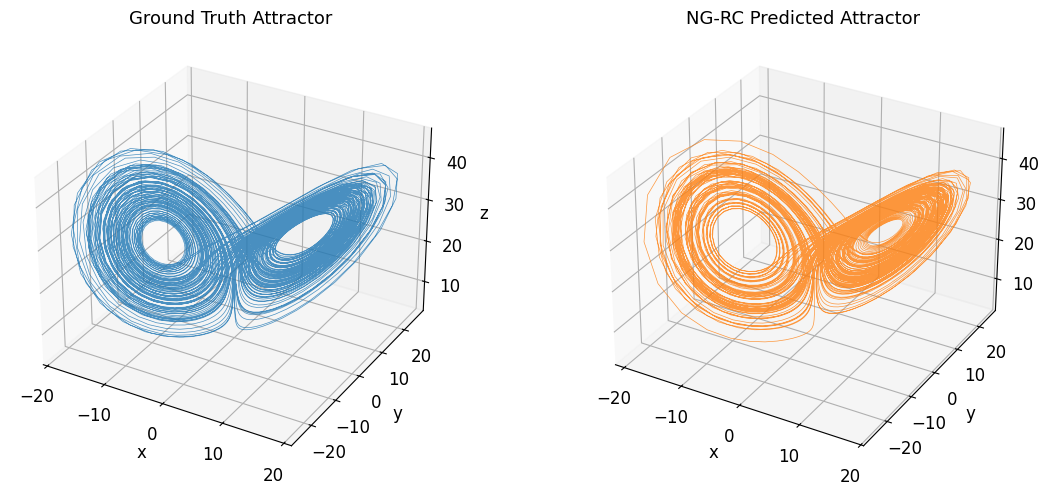

In [25]:
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(12, 5))

# Ground truth attractor (BLACK)
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(
    x[0, warmtrain_pts:maxtime_pts],
    x[1, warmtrain_pts:maxtime_pts],
    x[2, warmtrain_pts:maxtime_pts],
    linewidth=0.5,
    color='tab:blue',
    alpha=0.8
)

ax1.set_title('Ground Truth Attractor')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

# NG-RC predicted attractor (RED)
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(
    x_test[0, :],
    x_test[1, :],
    x_test[2, :],
    linewidth=0.5,
    color='tab:orange',
    alpha=0.8
)
ax2.set_title('NG-RC Predicted Attractor')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

plt.tight_layout()
plt.show()


### Reference

Gauthier, D. J., Bollt, E., Griffith, A., & Barbosa, W. A. S.  
*Next Generation Reservoir Computing*  

Original code repository:  
https://github.com/quantinfo/ng-rc-paper-code
